# The Multi-Armed Bandit Problem
## Bayesian Approach
---

## Navigation

1. [$K$-Armed Bandit](#$K$-Armed-Bandit)
1. [Exploration Strategy](#Exploration-Strategy)
1. [Thompson Sampling in Action](#Thompson-Sampling-in-Action)
1. [Comparison](#Comparison)
1. [ToDo](#ToDo)

---

<img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Las_Vegas_slot_machines.jpg" alt="Drawing" style="width: 600px;"/>

---

## $K$-Armed Bandit ($K$-MAB)

[Top](#The-Multi-Armed-Bandit-Problem)

### Problem Formulation

Consider the problem of gambaling $K$ slot machines in a casino. At each time step $t$ the gambler choose an action $a_t\in \mathcal{A}$ (i.e. which handle to pull) and observes a random outcome, $Y_t(a_t)\in \mathcal{Y}$. A known function $r:\mathcal{Y}\to \mathbb{R}$ associates the random outcome to a reward. **The gambler seeks to maximize the cumulative rewards**.

The outcomes ${Y_t(a)}$ are drawn i.i.d. over time from an unknown probability distribution $P(\cdot\mid a)\in P(Y)$, where P(Y) denotes the set of probability distributions on subsets of $\mathcal{Y}$. We will assume $Y_t(a)$ to follow a Bernoulli distribution (i.e. $\mathcal{Y}=\{0, 1\}$), with parameter $\theta_a$, and that the reward function $r$ is the identity function.

### Exploration - Exploitation and Regret

A key challenge in sequential decision making under uncertainty (as in the multi-armed bandit problem) is the *exploration/exploitation dilemma*: the tradeoff between either taking actions that are most rewarding according
to the current state of knowledge, or taking exploratory actions, which may be less immediately rewarding, but may lead to better informed decisions in the future.

Formally, this tradeoff is captured by the notion of *regret*:

Let $a^*\in \arg \max_{a\in\mathcal{A}} \mathbb{E}[r(y(a))]$, denote the optimal arm. The $T$-period regret of the sequence of actions $a_1, . . . , a_T$ is the random variable,

$$\text{Regret}(T) = \sum_{t=1}^T \big[r(Y_t(a^*)) - r(Y_t(a_t))\big]$$

Typically, we focus on the expected regret $\mathbb{E}[\text{Regret}(T)]$.

### Bayesian Approach to MAB

We will assume that the unknown parameters $\theta_a, a\in \mathcal{A}$ are drawn from a prior distribution $\text{Beta}(\alpha_{\theta}, \beta_{\theta})$. Given an observation, $Y(a)=y$ for action $a$, we update (i.e. calculate the posterior) the distribution for $\theta_a$ as follow:

$$
\begin{aligned}
 P(\theta_a\mid y)&\propto P(y\mid \theta_a) \cdot P(\theta_a) \\
 &\propto \theta_a^y (1-\theta_a)^{1-y} \cdot \theta_a^{\alpha_a-1}(1-\theta_a)^{\beta_a-1} \\
 &\propto \theta_a^{\alpha_a + y - 1} \cdot (1-\theta_a)^{\beta_a+1-y-1}
\end{aligned}
$$

Meaning that $\theta_a\mid y \sim \text{Beta}(\alpha_a+y, \beta_a+1-y)$. Also note that the (posterior) expected reward for arm $a$ is now, 

$$\mathbb{E}[r(Y(a))] = \mathbb{E}_{\theta_a} \mathbb{E}_Y [Y(a)\mid \theta_a] = \mathbb{E}[\theta_a] = 
\frac{\alpha_a + y}{\alpha_a + y + \beta_a-y+1}$$

The Bayesian approach will also allow us to estimate the uncertainty about the outcome probabilities at each step, which may be used for guiding the exploration to more relevant areas.

## Exploration Strategy

[Top](#The-Multi-Armed-Bandit-Problem)

### $\epsilon-$greedy

Set $0<\epsilon<1$. At each step:
   - Choose the best arm so far (i.e. $\arg\max_{a} \mathbb{E}[\theta_a]$) w.p $1-\epsilon$.
   - Choose a random arm, w.p $\epsilon$.
   
There are of course generalization of the algorithm to allow for adaptive/decreasing epsilon strategy.
   
### Upper Confidence Bound

For the Upper Confidence Bound (UCB) we associate each arm with its expected reward, and confidence bound over that reward. At each step, we choose to play the arm with the highest upper confidence bound value. 

This approach uses the uncertainty we have about the true parameters, in order to apply a more adaptive exploration strategy.
   
### Thompson Sampling

How can we use the uncertainty about the outcome probabilities $\theta\in\mathbb{R}^K$ captured by the posterior distribution to perform a better exploration strategy?

The Thompson Sampling algorithm (TS) suggests a natural Bayesian approach to the MAB problem using randomized probability matching. At each step $t$:
    
   - Sample $\hat{\theta}$ from the current distribution over $\theta$.
   - Choose arm $a_t=\arg\max_a\mathbb{E}[r(Y(a))]$
   - Observe outcome $Y_t$ and update the postirior distribution

## Referance

1. [Ghavamzadeh, Mohammad, et al. "Bayesian reinforcement learning: A survey." Foundations and Trends® in Machine Learning 8.5-6 (2015): 359-483.](https://www.nowpublishers.com/article/Details/MAL-049)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta, bernoulli

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
%matplotlib notebook

#import imageio
from matplotlib.animation import FuncAnimation

## Thompson Sampling in Action

[Top](#The-Multi-Armed-Bandit-Problem)

In [2]:
class UpdateDist(object):
    def __init__(self, ax, K = 10, 
                 probs = None, ylim = (0, 20)):
        self.K = K
        self.success = np.zeros(K)
        self.trails = np.zeros(K)
        if probs is not None:
            assert (len(probs) == K and ((0 < np.array(probs)) & (np.array(probs) < 1)).all()), \
                    "probs must be of length K, with enteries in (0, 1)."
        self.probs = np.random.rand(K) if probs is None else probs
        self.alphas = np.ones(K)
        self.betas = np.ones(K)
        
        self.lines = np.zeros(K)
        colormap = get_cmap('viridis')
        self.colors = [rgb2hex(colormap(col)) for col in self.probs] # np.linspace(0, 1, K)
        self.lines = [ax.plot([],[], lw = 2, color = self.colors[i])[0] for i in range(K)]
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(ylim)
        self.ax.grid(True)

        # This vertical lines represent the theoretical value, to
        # which the plotted distribution should converge.
        for i, prob in enumerate(self.probs):
            self.ax.axvline(prob, linestyle='--', color=self.colors[i])

    def init(self):
        self.success = np.zeros(self.K)
        self.trails = np.zeros(self.K)
        self.alphas = np.ones(self.K)
        self.betas = np.ones(self.K) 
        for line in self.lines:
            line.set_data([], [])
        return self.lines,
    
    def choose_arm(self):
        return np.argmax([beta(a, b).rvs() for a, b in zip(self.alphas, self.betas)])

    def __call__(self, trail):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if trail == 0:
            return self.init()
        # choose arm with to TS
        indx = self.choose_arm()
        self.trails[indx] += 1
        curr_y = bernoulli(self.probs[indx]).rvs()
        self.success[indx] += curr_y
        self.alphas[indx] += curr_y
        self.betas[indx] += (1 - curr_y)
        y = beta.pdf(self.x, self.success[indx] + self.alphas[indx], 
                     (trail - self.success[indx]) + self.betas[indx])
        self.xlist = [self.x for _ in range(self.K)]
        self.ylist = [beta.pdf(self.x, self.success[i] + self.alphas[i], 
                                 (self.trails[i] - self.success[i]) + self.betas[i]) for i in range(self.K)]
        for lnum, line in enumerate(self.lines):
            line.set_data(self.xlist[lnum], self.ylist[lnum])
        self.ax.set_title("Step {}".format(trail+1))
        return self.lines,

<IPython.core.display.Javascript object>


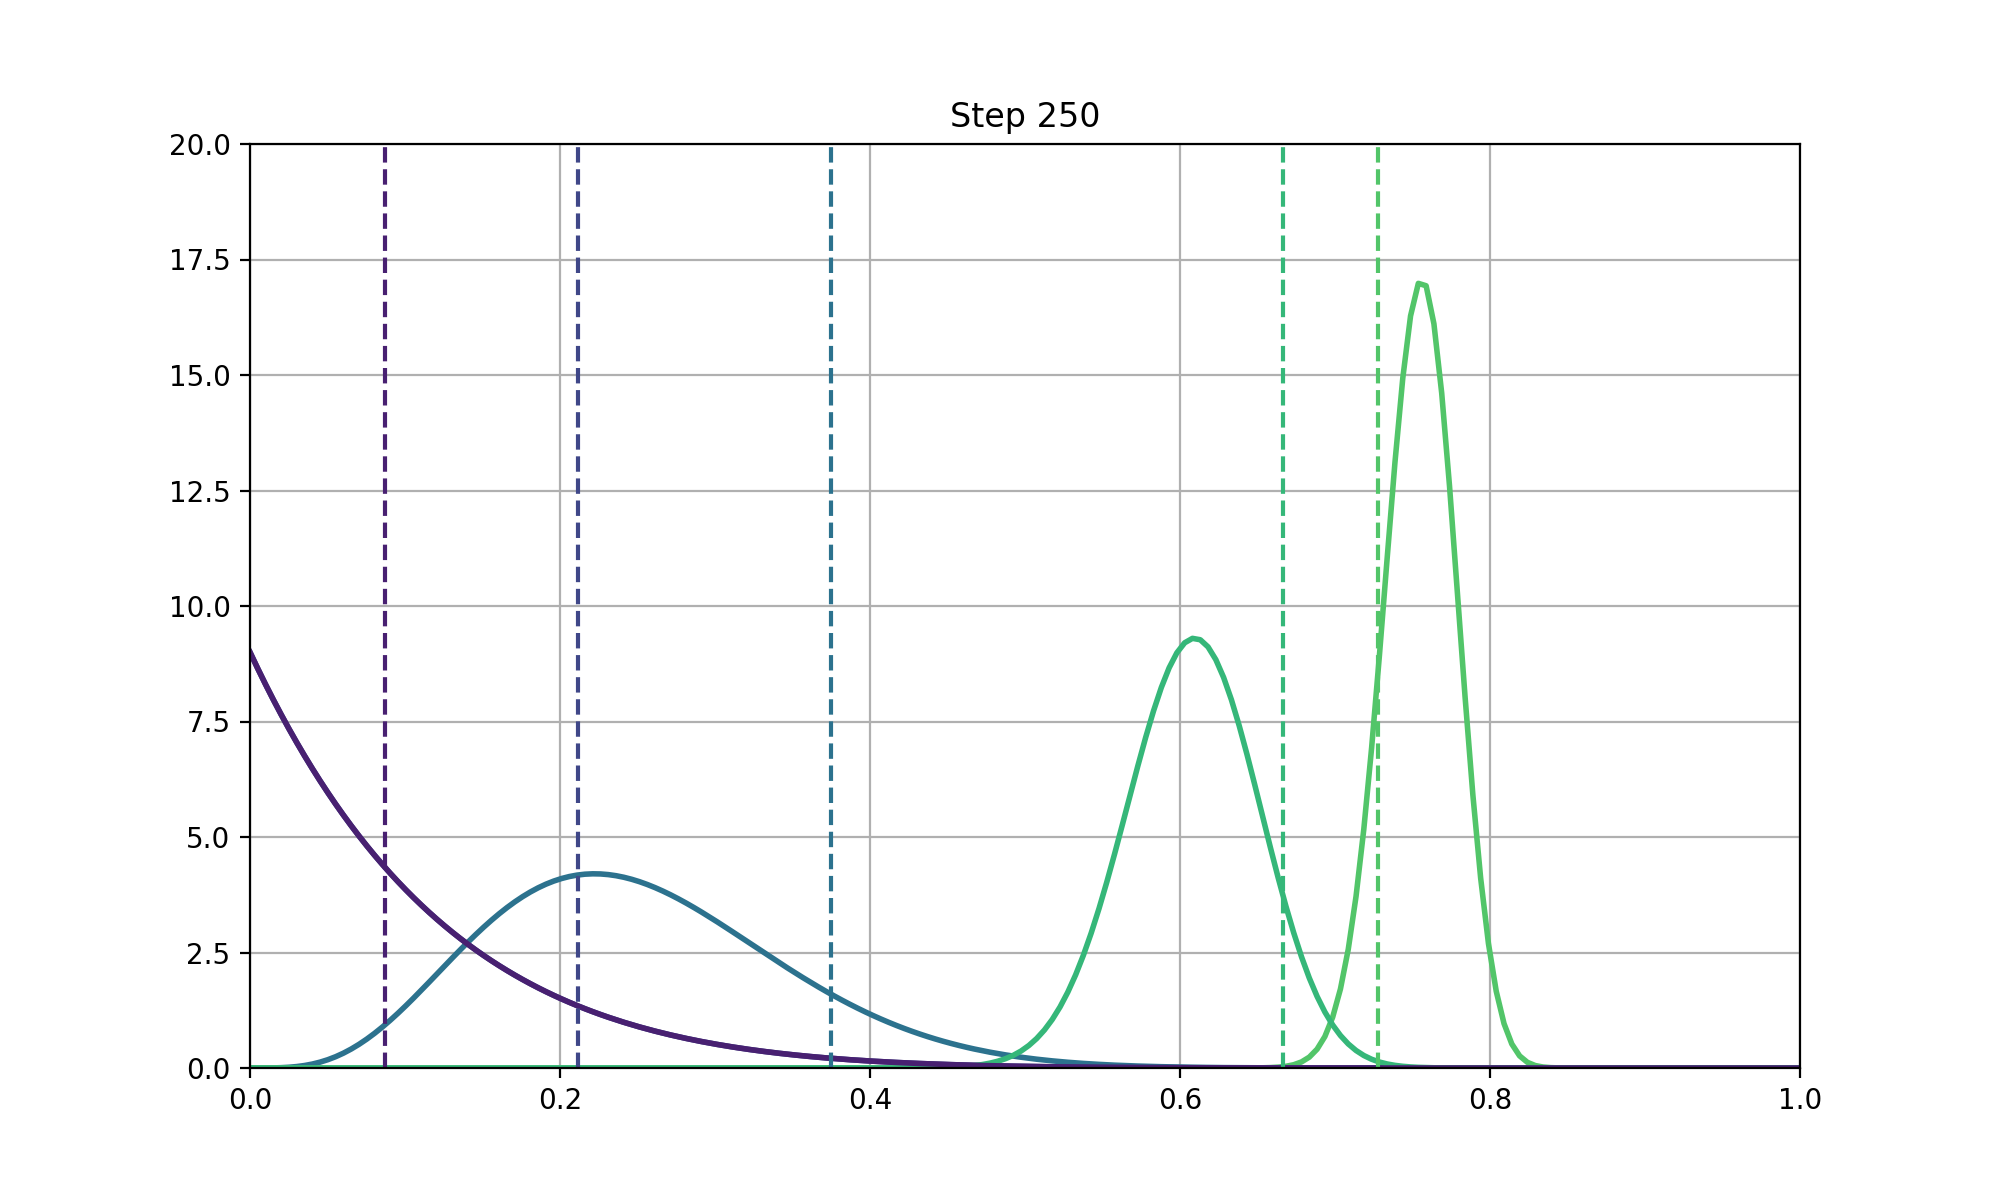

In [109]:
SAVE = False

fig, ax = plt.subplots(figsize = (10, 6))
ud = UpdateDist(ax, K = 5, ylim = (0, 20))


anim = FuncAnimation(fig, ud, frames = np.arange(250), 
                     init_func = ud.init, interval = 10,
                     blit = True, repeat = False)
if SAVE:
    anim.save('../images/ts-brl1.gif', dpi=80, writer='imagemagick') # you must install imagemagick
                                                                     # in order to save .gif
else:
    plt.show()

## Comparison

[Top](#The-Multi-Armed-Bandit-Problem)

### $\epsilon-$greedy vs. TS vs. UCB

We will compare the algorithms using the expectet *regret*.

## ToDo

[Top](#The-Multi-Armed-Bandit-Problem)

1. Add comperison of TS, $\epsilon-$greedy and UCB.